## Predicting Home Loans

Source: https://www.kaggle.com/ufffnick/loan-prediction-dream-housing-finance   
Data: https://www.kaggle.com/burak3ergun/loan-data-set

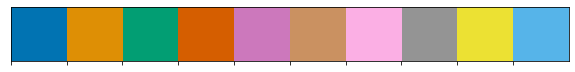

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from scipy.stats import skew, kurtosis


# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

#plt.style.use('dark_background')
current_palette = sns.color_palette('colorblind')
sns.palplot(current_palette)

### import data

In [12]:
data_set = pd.read_csv('../data/loan_data_set.csv')
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [13]:
# categorical variables
print('\n',data_set[['Loan_Amount_Term']].value_counts().head())
print('\n',data_set[['Property_Area']].value_counts())
print('\n',data_set[['Gender']].value_counts())
print('\n',data_set[['Education']].value_counts())
print('\n',data_set[['Self_Employed']].value_counts())
print('\n', data_set[['Credit_History']].value_counts())


 Loan_Amount_Term
360.0               512
180.0                44
480.0                15
300.0                13
84.0                  4
dtype: int64

 Property_Area
Semiurban        233
Urban            202
Rural            179
dtype: int64

 Gender
Male      489
Female    112
dtype: int64

 Education   
Graduate        480
Not Graduate    134
dtype: int64

 Self_Employed
No               500
Yes               82
dtype: int64

 Credit_History
1.0               475
0.0                89
dtype: int64


In [14]:
# this will display well in 3D
data_set[['LoanAmount','ApplicantIncome','CoapplicantIncome']].describe()

,LoanAmount,ApplicantIncome,CoapplicantIncome
count,592.000000,614.000000,614.000000
mean,146.412162,5403.459283,1621.245798
std,85.587325,6109.041673,2926.248369
min,9.000000,150.000000,0.000000
25%,100.000000,2877.500000,0.000000
50%,128.000000,3812.500000,1188.500000
75%,168.000000,5795.000000,2297.250000
max,700.000000,81000.000000,41667.000000


- drop all NAs
- previous attempts to fill the gaps showed that most frequent dummy classifier bring the best results, although increases the bias within the data

In [15]:
data_set.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [16]:
# remove missing data
data_set.dropna(inplace=True)
data_set.reset_index(drop=True, inplace=True)

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [17]:
data_set['Property_Area'].value_counts()

Semiurban    191
Urban        150
Rural        139
Name: Property_Area, dtype: int64

In [18]:
# preprocess the dataset
def categorize(df):
    df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
    df['Education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df['Loan_Status'].replace({'Y': 1, 'N':0}, inplace=True)
    df['Self_Employed'].replace({'Yes': 1, 'No': 0}, inplace = True)
    df['LoanAmount'] = df['LoanAmount']*1000
    return df

In [19]:
# apply the changes
print(data_set.shape)
data_set = categorize(data_set)
print(data_set.shape)
data_set.head(2).T

(480, 13)
(480, 13)


,0,1
Loan_ID,LP001003,LP001005
Gender,1,1
Married,Yes,Yes
Dependents,1,0
Education,1,1
Self_Employed,0,1
ApplicantIncome,4583,3000
CoapplicantIncome,1508.0,0.0
LoanAmount,128000.0,66000.0
Loan_Amount_Term,360.0,360.0


### Adding new features:
- one hot encoding
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) 
- total income (ApplicantIncome + CoaplicantIncome) 
- both standardized and with ln() to get the distribution as close as possible to a normal distribution

In [21]:
# onehot encoding of categorical variables

encoder1=OneHotEncoder()
ohe=pd.DataFrame(encoder1.fit_transform(data_set[['Property_Area']]).toarray())
col_list = ['Property_Area_{}'.format(item) for item in data_set['Property_Area'].value_counts().index]
ohe.columns=col_list
data_set = pd.concat([data_set, ohe],axis=1)

In [22]:
# standardization

ss_scaler1 = StandardScaler()
ss_scaler2 = StandardScaler()
ss_scaler3 = StandardScaler()


ln_monthly_return_raw  = np.log(data_set['LoanAmount']/data_set['Loan_Amount_Term']).values
data_set['ln_monthly_return'] = ss_scaler1.fit_transform(np.array(ln_monthly_return_raw).reshape(-1, 1))

ln_total_income_raw = np.log(data_set['ApplicantIncome'] + data_set['CoapplicantIncome'])
data_set['ln_total_income'] = ss_scaler2.fit_transform(np.array(ln_total_income_raw).reshape(-1, 1)) 

ln_LoanAmount_raw = np.log(1000*data_set['LoanAmount'])
data_set['ln_LoanAmount'] = ss_scaler3.fit_transform(np.array(ln_LoanAmount_raw).reshape(-1, 1)) 

In [24]:
# drop additional variables that are reformatted or don't add much to the analysis.
dropit=['Loan_ID', 'Married', 'Dependents', 'Property_Area', 'Property_Area_Rural', 'LoanAmount',
        'Loan_Amount_Term','ApplicantIncome','CoapplicantIncome']
data_set.drop(columns=dropit, 
           inplace=True)

### The following are the main functions to run each model evaluation in the chosen best values

In [25]:
def mod_eval(df,predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df.Loan_Status[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df.Loan_Status[y_test.index], predictions))
    
    f, axes = plt.subplots(1,2,figsize= (20,6),squeeze=False)

    fpr, tpr, _ = roc_curve(df.Loan_Status[y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)
    axes[0,0].plot(fpr, tpr, lw=3)
    axes[0,0].set_title('{} ROC curve (area = {:0.2f})'.format(title, roc_auc))
    axes[0,0].set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    axes[0,0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall)) # set the best index to be the minimum delta between precision and recall
    axes[0,1].plot(precision,recall)
    axes[0,1].set_title('{} Precision-Recall Curve'.format(title))
    axes[0,1].set(xlabel='Precision', ylabel='Recall', xlim=(0.4,1.05))
    axes[0,1].plot(precision[best_index],recall[best_index],'o',color='r')
    axes[0,1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

In [26]:
def model_training(classifier,df):
    clf = classifier
    t=df.drop(columns=['Loan_Status'])
    X_train, X_test, y_train, y_tests = train_test_split(t,
                                                         df['Loan_Status'],
                                                         test_size=ts,
                                                         stratify=df['Loan_Status'])
    clf.fit(X_train, y_train)
    return clf

### Chosen values per model

In [27]:
#RandomForest
max_depth=11
max_features=6

In [28]:
#LogisticRegression
lr_C=0.1
penalty='l1'

In [29]:
#SVC
svc_C=1
gamma=0.9

In [30]:
#Test Size
ts = 0.333

## RandomForest

              precision    recall  f1-score   support

           0       0.90      0.73      0.81        49
           1       0.89      0.96      0.93       111

    accuracy                           0.89       160
   macro avg       0.90      0.85      0.87       160
weighted avg       0.89      0.89      0.89       160



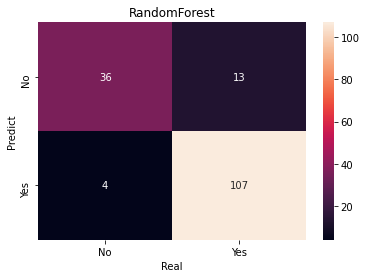

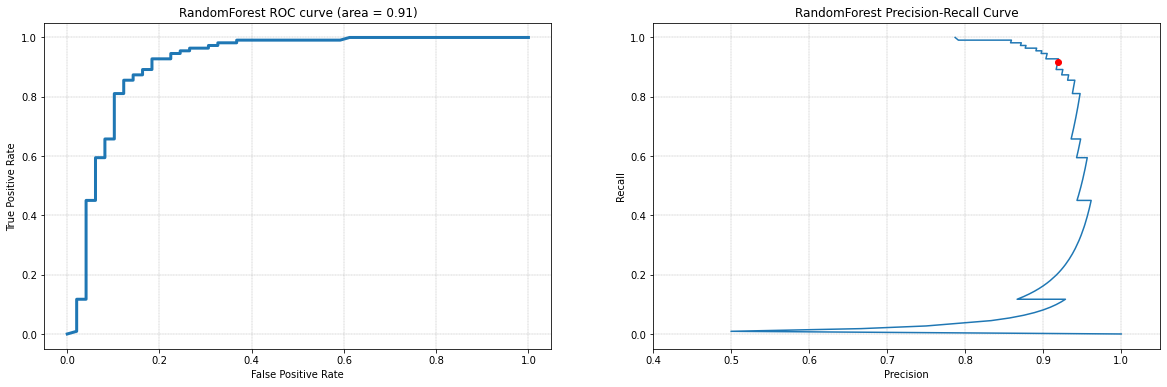

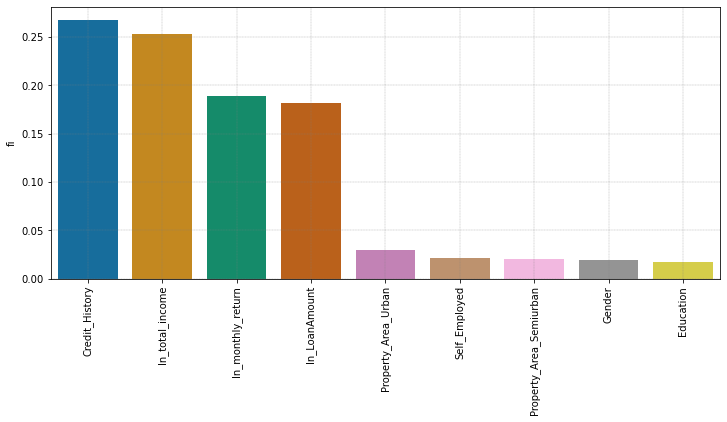

In [31]:
rf = model_training(RandomForestClassifier(random_state=42, 
                                           n_jobs=4, 
                                           n_estimators=50, 
                                           max_depth=max_depth,
                                           max_features=max_features),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                     data_set['Loan_Status'],
                                                     test_size=ts,
                                                     stratify=data_set['Loan_Status'])

mod_eval(data_set, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=t.columns).sort_values(by='fi', ascending=False)
fi_df
plt.show()
plt.figure(figsize=(12,5))
plt.xticks(rotation='vertical')
sns.barplot(x=fi_df.index, y=fi_df['fi'], palette=current_palette)
plt.grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')
plt.show()

## LogisticRegression

              precision    recall  f1-score   support

           0       0.90      0.55      0.68        49
           1       0.83      0.97      0.90       111

    accuracy                           0.84       160
   macro avg       0.87      0.76      0.79       160
weighted avg       0.85      0.84      0.83       160



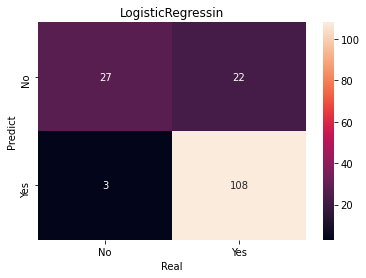

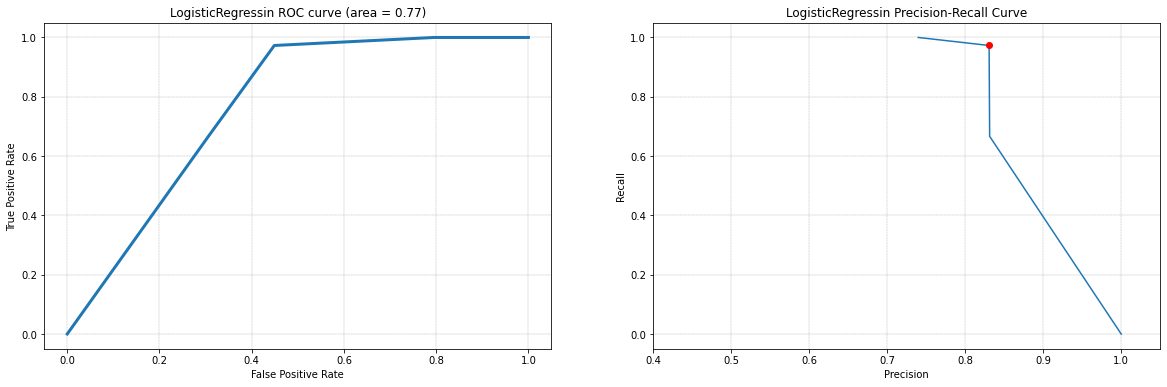

In [32]:
lr = model_training(LogisticRegression(C=lr_C, 
                                       penalty=penalty,
                                       solver='liblinear',
                                       max_iter=1000),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

#pred_y = lr.predict(X_test)
mod_eval(data_set, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegressin') 
plt.show()

## NaiveBayes

              precision    recall  f1-score   support

           0       0.73      0.61      0.67        49
           1       0.84      0.90      0.87       111

    accuracy                           0.81       160
   macro avg       0.79      0.76      0.77       160
weighted avg       0.81      0.81      0.81       160



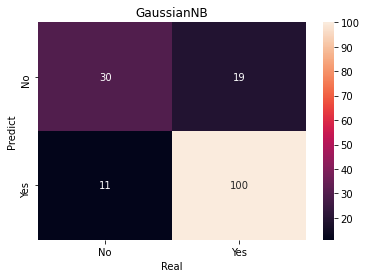

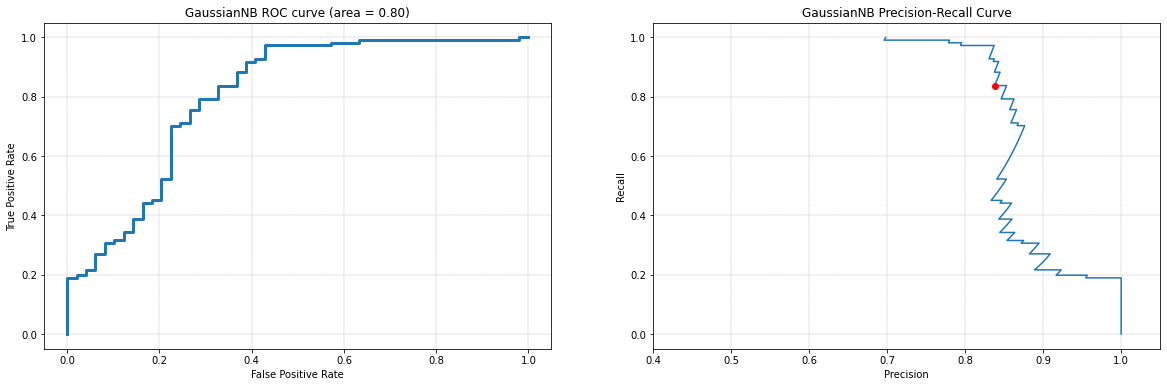

In [33]:
gnb = model_training(GaussianNB(),data_set)

t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])


t = 0.75
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = gnb.predict(X_test)
mod_eval(data_set,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

## SVC

t=0.75
              precision    recall  f1-score   support

           0       0.90      0.55      0.68        49
           1       0.83      0.97      0.90       111

    accuracy                           0.84       160
   macro avg       0.87      0.76      0.79       160
weighted avg       0.85      0.84      0.83       160



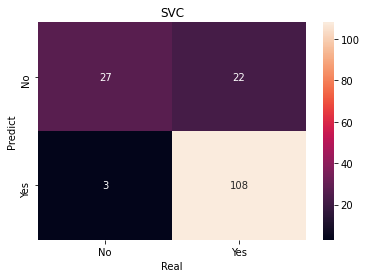

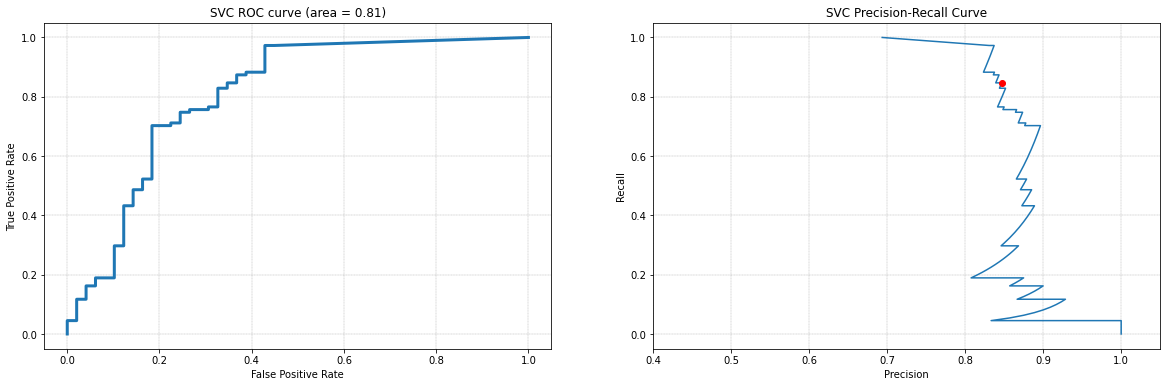

In [34]:
svc = model_training(SVC(kernel='linear',
                         C=1, 
                         gamma='auto',
                         class_weight='balanced',
                         probability=True),data_set)


t=data_set.drop(columns=['Loan_Status'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Loan_Status'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Loan_Status'])

t=0.75
print('t={}'.format(t))
predprob = svc.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = svc.predict(X_test)

mod_eval(data_set,pred_y, svc.predict_proba(X_test), y_test, 'SVC')
plt.show()

## Summary
- The RandomForest classifier brings the best results
- Although, it might seems a bit overfitted according the CrossValidation session before the last fitting

In [35]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test)]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.95, 0.84375, 0.85, 0.84375]

In [36]:
# compare final models: ROCAUC

roc_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(rf.predict(X_test), y_test.values))
roc_vals

[0.9516908212560387,
 0.9516908212560387,
 0.9516908212560387,
 0.9516908212560387]

In [37]:
# display final values
models = ['random forest', 'linear regression', 'naive bayes', 'support vector', 'dummy']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

,accuracy,rocauc
model,,
random forest,0.95000,0.951691
linear regression,0.84375,0.951691
naive bayes,0.85000,0.951691
support vector,0.84375,0.951691


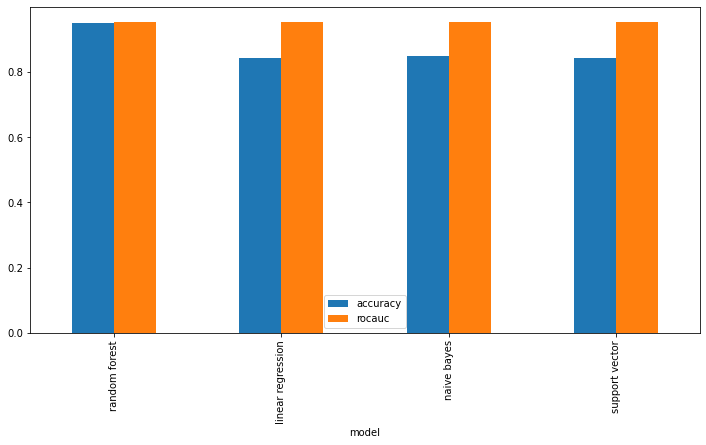

In [38]:
# Plot a bar chart using the DF
ax = evaldf.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(12, 6)

In [64]:
# Random Forest feature importance
fi_df

,fi
Credit_History,0.267864
ln_total_income,0.252863
ln_monthly_return,0.189391
ln_LoanAmount,0.181649
Property_Area_Urban,0.029617
Self_Employed,0.021493
Property_Area_Semiurban,0.020036
Gender,0.019707
Education,0.017380


In [40]:
# what are the key variables like?
X_test[['Credit_History', 'ln_total_income', 'ln_monthly_return', 'ln_LoanAmount']].head(2).T

,301,308
Credit_History,1.000000,1.000000
ln_total_income,-0.111418,-0.084437
ln_monthly_return,-0.182922,-0.426292
ln_LoanAmount,-0.039276,-0.307943


## Predict on new data

In [41]:
# one row of data
data_set = pd.read_csv('../data/loan_data_set.csv')
data_set.loc[1, ['Credit_History',
'LoanAmount',
'Loan_Amount_Term',
'ApplicantIncome',
'CoapplicantIncome',
 'Property_Area',
 'Gender',
 'Education',
  'Self_Employed'
 ]].values

array([1.0, 128.0, 360.0, 4583, 1508.0, 'Rural', 'Male', 'Graduate', 'No'],
      dtype=object)

In [76]:
# create some fake new data
newdatadf = pd.DataFrame(columns=['Credit_History',
'LoanAmount',
'Loan_Amount_Term',
'ApplicantIncome',
'CoapplicantIncome',
 'Property_Area',
 'Gender',
 'Education',
  'Self_Employed'
 ])

new_data=[1.0, 128.0, 360.0, 4583, 1508.0, 'Rural', 'Male', 'Graduate', 'No']
newdatadf.loc[0] = new_data
newdatadf

,Credit_History,LoanAmount,Loan_Amount_Term,ApplicantIncome,CoapplicantIncome,Property_Area,Gender,Education,Self_Employed
0,1.0,128.0,360.0,4583,1508.0,Rural,Male,Graduate,No


In [81]:
# preprocess the dataset
def categorize(df):
    df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
    df['Education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df['Self_Employed'].replace({'Yes': 1, 'No': 0}, inplace = True)
    df['LoanAmount'] = df['LoanAmount']*1000
    # onehot encoding
    ohe=pd.DataFrame(encoder1.transform(df[['Property_Area']]).toarray())
    col_list = ['Property_Area_{}'.format(item) for item in ['Semiurban', 'Urban', 'Rural']]
    ohe.columns=col_list
    df = pd.concat([df, ohe],axis=1)
    # create new features using the scalers we trained earlier

    ln_monthly_return_raw  = np.log(df['LoanAmount']/df['Loan_Amount_Term']).values
    df['ln_monthly_return'] = ss_scaler1.transform(np.array(ln_monthly_return_raw).reshape(-1, 1))

    ln_total_income_raw = np.log(int(df['ApplicantIncome']) + int(df['CoapplicantIncome']))
    df['ln_total_income'] = ss_scaler2.transform(np.array(ln_total_income_raw).reshape(-1, 1)) 

    ln_LoanAmount_raw = np.log(1000*df['LoanAmount'])
    df['ln_LoanAmount'] = ss_scaler3.transform(np.array(ln_LoanAmount_raw).reshape(-1, 1)) 

    df=df.drop(['LoanAmount', 'Loan_Amount_Term', 'ApplicantIncome', 'CoapplicantIncome', 
            'Property_Area', 'Property_Area_Rural'], axis=1)
    return df

In [87]:
newdatatransformed=categorize(newdatadf)

In [88]:
newdatatransformed.columns

Index(['Credit_History', 'Gender', 'Education', 'Self_Employed',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'ln_monthly_return',
       'ln_total_income', 'ln_LoanAmount'],
      dtype='object')

In [85]:
print(X_test.columns)

Index(['Gender', 'Education', 'Self_Employed', 'Credit_History',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'ln_monthly_return',
       'ln_total_income', 'ln_LoanAmount'],
      dtype='object')


In [93]:
newdatatransformed[cols, :]

TypeError: '(['Gender', 'Education', 'Self_Employed', 'Property_Area_Semiurban', 'Property_Area_Urban', 'ln_monthly_return', 'ln_total_income', 'ln_LoanAmount', 'Credit_History'], slice(None, None, None))' is an invalid key

In [92]:
cols = [ 'Gender', 'Education', 'Self_Employed',
       'Property_Area_Semiurban', 'Property_Area_Urban', 'ln_monthly_return',
       'ln_total_income', 'ln_LoanAmount', 'Credit_History']

In [ ]:
rf.predict(X_test), rf.predict_proba(X_test)